In [1]:
# Specify keras model

import numpy as np
from keras.layers import Dense
from keras.models import Sequential


Using TensorFlow backend.


In [2]:
import gensim
import sklearn.datasets

from sklearn.cross_validation import train_test_split
from sklearn.svm import SVC
from sklearn import metrics

/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [ ]:
# Create a dataframe containing all the labelled text data from Curation

import json
import time
import argparse
import os
import pandas as pd
from pandas.io.json import json_normalize

columns = ["Title", "PublishedDate","Body","Source_name","Source_url","Category"]
index = np.arange(1)
all_articles_df = pd.DataFrame(columns=columns, index=index)

for filename in os.listdir("./data/"):
    if filename.endswith(".json"):
        #with open(os.path.join("./data/", filename)) as f:
        #    content = f.read()
        
        # Load json as string
        articles = json.load(open(os.path.join("./data/", filename)))

        # Normalise (i.e. breakout) nested Sources into Title and Url fields
        norm_articles_json = json_normalize(articles, "Sources")
        sources_df = norm_articles_json[["Title", "Url"]].copy()

        # Rename columns to maintain consistency with training data
        new_sources_df = sources_df.rename(columns={"Title": "Source_name", "Url": "Source_url"})

        # Load original articles as Pandas dataframe
        articles_df = pd.read_json(open(os.path.join("./data/", filename)))

        # Select the other relevant columns
        cleaned_articles_df = articles_df[["Title", "PublishedDate", "Body"]].copy()

        # Concatenate the relevant columns with the normalised sources columns
        full_articles_df = pd.concat([cleaned_articles_df, new_sources_df], axis = 1)

        # Drop rows containing NaNs
        full_articles_nn = full_articles_df.dropna(how="any")

        label = os.path.splitext(filename)[0]
        category = []
        for row in full_articles_nn['Body']:
            category.append(label)
        full_articles_nn["Category"] = category
        all_articles_df = pd.concat([all_articles_df, full_articles_nn], axis=0)
        
all_articles_df = all_articles_df.drop([0])
# all_articles_df


In [5]:
# Look at values of each kind of article

all_articles_df["Category"].value_counts()

cpr_articles         6846
blackswans           4837
batterytech          4092
financialservices    3986
carboneradication    3690
sharingeconomy       3574
digitalads           2920
internetofthings     2627
property             2132
digitalhealth        1943
digitalcurrency      1914
ai                   1722
blockchain           1650
educationtech        1555
Name: Category, dtype: int64

In [6]:
all_articles_df.to_csv("all_articles_df.csv")

In [ ]:
# Create a more balanced dataset for later use

appended = all_articles_df

In [71]:
#appended = all_articles_df
#values = pd.DataFrame(all_articles_df["Category"].value_counts())

#for category, value in values:
#    df_row = appended['Category'] == category
#    df_append = appended[df_row]
#    appended = appended.append([df_append]*(int(13692/value)), ignore_index=True)

#appended['Category'].value_counts()

# the following code copies a category's content and adds it to a
# new dataset, df_append. The code above tries to do this automatically
# exact proportion, but doesn't work! In the end it was just easier to 
# build the balanced dataset manually, by using the code below.

df_row = all_articles_df['Category'] == "batterytech"
df_append = all_articles_df[df_row]
appended = appended.append([df_append], ignore_index=True)
appended['Category'].value_counts()

batterytech          16368
financialservices    15944
internetofthings     15762
digitalhealth        15544
digitalcurrency      15312
property             14924
carboneradication    14760
digitalads           14600
blackswans           14511
sharingeconomy       14296
educationtech        13995
ai                   13776
cpr_articles         13692
blockchain           13200
Name: Category, dtype: int64

In [ ]:
# Shuffle and simplify the dataframe in preparation for doing a train/test split
bal_shuffled_df = appended.sample(frac=1).reset_index(drop=True)
bal_shuffled_df = bal_shuffled_df.drop(["PublishedDate", "Source_name", "Source_url"], axis=1)
bal_shuffled_df["Text"] = bal_shuffled_df["Title"] + bal_shuffled_df["Body"]
# bal_shuffled_df

In [73]:
bal_shuffled_df.shape

(206684, 4)

In [74]:
bal_shuffled_df.to_csv("bal_shuffled_df.csv")

In [75]:
appended.to_csv("appended.csv")

In [ ]:
# Shuffle and simplify the original unbalanced dataframe in preparation for doing a train/test split
shuffled_df = all_articles_df.sample(frac=1).reset_index(drop=True)
shuffled_df = shuffled_df.drop(["PublishedDate", "Source_name", "Source_url"], axis=1)
# shuffled_df

In [ ]:
shuffled_df["Text"] = shuffled_df["Title"] + shuffled_df["Body"]
# shuffled_df

In [9]:
shuffled_df.to_csv("shuffled_df.csv")

In [11]:
# Split data into train and test
train_size = int(len(shuffled_df) * .8)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(shuffled_df) - train_size))

Train size: 34790
Test size: 8698


In [13]:
train_posts = shuffled_df["Text"][:train_size]
train_tags = shuffled_df["Category"][:train_size]

test_posts = shuffled_df["Text"][train_size:]
test_tags = shuffled_df["Category"][train_size:]

Now we have our data, the first step is to try it on a simple multi-layer perceptron network, as follows.

In [14]:
import keras.preprocessing.text as text

max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_posts) # only fit on train
x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

In [11]:
x_train

array([[ 0.,  1.,  1., ...,  0.,  1.,  0.],
       [ 0.,  1.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  1., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  1.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  1., ...,  0.,  0.,  0.]])

In [12]:
# Use sklearn utility to convert label strings to numbered index
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

In [13]:
from tensorflow.contrib.keras.python.keras import utils

# Converts the labels to a one-hot representation
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [14]:
y_train

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

In [15]:
# Inspect the dimenstions of our training and test data (this is helpful to debug)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (34790, 1000)
x_test shape: (8698, 1000)
y_train shape: (34790, 14)
y_test shape: (8698, 14)


In [16]:
# This model trains very quickly and 2 epochs are already more than enough
# Training for more epochs will likely lead to overfitting on this dataset
# You can try tweaking these hyperparameters when using this model with your own data
batch_size = 32
epochs = 2

In [17]:
# Build the model
model = Sequential()

Now we can add our input layer. The input layer will take the vocab_size arrays for each comment. We’ll specify this as a Dense layer in Keras, which means each neuron in this layer will be fully connected to all neurons in the next layer. We pass the Dense layer two parameters: the dimensionality of the layer’s output (number of neurons) and the shape of our input data. Choosing the number of dimensions requires some experimentation, and there is a lot of discussion on the best approach for doing this. It’s common to use a power of 2 as the number of dimensions, so we’ll start with 512. The number of rows in our input data will be the number of posts we’re feeding the model at each training step (called batch size), and the number of columns will be the size of our vocabulary. With that, we’re ready to define the Dense input layer. The activation function tells our model how to calculate the output of a layer. 

In [18]:
from keras.layers import Dense, Activation, Dropout

model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

In [19]:
# Define output layer (number of labels) and type of layer

model.add(Dense(num_classes))
model.add(Activation('softmax'))

To prepare our model for training, we need to call the compile method with the loss function we want to use, the type of optimizer, and the metrics our model should evaluate during training and testing. We’ll use the cross entropy loss function, since each of our comments can only belong to one post. The optimizer is the function our model uses to minimize loss. In this example we’ll use the Adam optimizer. 

In [20]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

To train our model, we’ll call the fit() method, pass it our training data and labels, the number of examples to process in each batch (batch size), how many times the model should train on our entire dataset (epochs), and the validation split. validation_split tells Keras what percentage of our training data to reserve for validation.

In [21]:
# model.fit trains the model
# The validation_split param tells Keras what % of our training data should be used in the validation set
# You can see the validation loss decreasing slowly when you run this
# Because val_loss is no longer decreasing we stop training to prevent overfitting
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 31311 samples, validate on 3479 samples
Epoch 1/2
31311/31311 [==============================] - 13s 402us/step - loss: 1.0319 - acc: 0.6820 - val_loss: 0.7931 - val_acc: 0.7356
Epoch 2/2
31311/31311 [==============================] - 12s 396us/step - loss: 0.7140 - acc: 0.7586 - val_loss: 0.7703 - val_acc: 0.7318


In [22]:
# Evaluate the accuracy of our trained model
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

8698/8698 [==============================] - 1s 91us/step
Test score: 0.767135069093
Test accuracy: 0.72453437576


In [23]:
# Here's how to generate a prediction on individual examples
text_labels = encoder.classes_ 

for i in range(10):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print(test_posts.iloc[i][:50], "...")
    print('Actual label:' + test_tags.iloc[i])
    print("Predicted label: " + predicted_label + "\n")

Sigfox expands its IoT networking into Germany ...
Actual label:internetofthings
Predicted label: internetofthings

Post-trade intermediaries may be replaced by block ...
Actual label:financialservices
Predicted label: financialservices

VW submits diesel plan update in California
<p>Vol ...
Actual label:batterytech
Predicted label: batterytech

UK energy schemes to cost households an extra £100 ...
Actual label:carboneradication
Predicted label: carboneradication

ebase teams with Fincite to help insurers with rob ...
Actual label:financialservices
Predicted label: financialservices

OCBC gains after Great Eastern sells Vietnam busin ...
Actual label:cpr_articles
Predicted label: cpr_articles

CapGemini to develop blockchain rewards system
<p> ...
Actual label:digitalcurrency
Predicted label: blockchain

Allianz revamps strategy to deal with current envi ...
Actual label:cpr_articles
Predicted label: cpr_articles

Brands race to adopt vertical video like Facebook  ...
Actual label:dig

In [24]:
y_softmax = model.predict(x_test)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

In [25]:
import matplotlib.pyplot as plt

# This utility function is from the sklearn docs: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

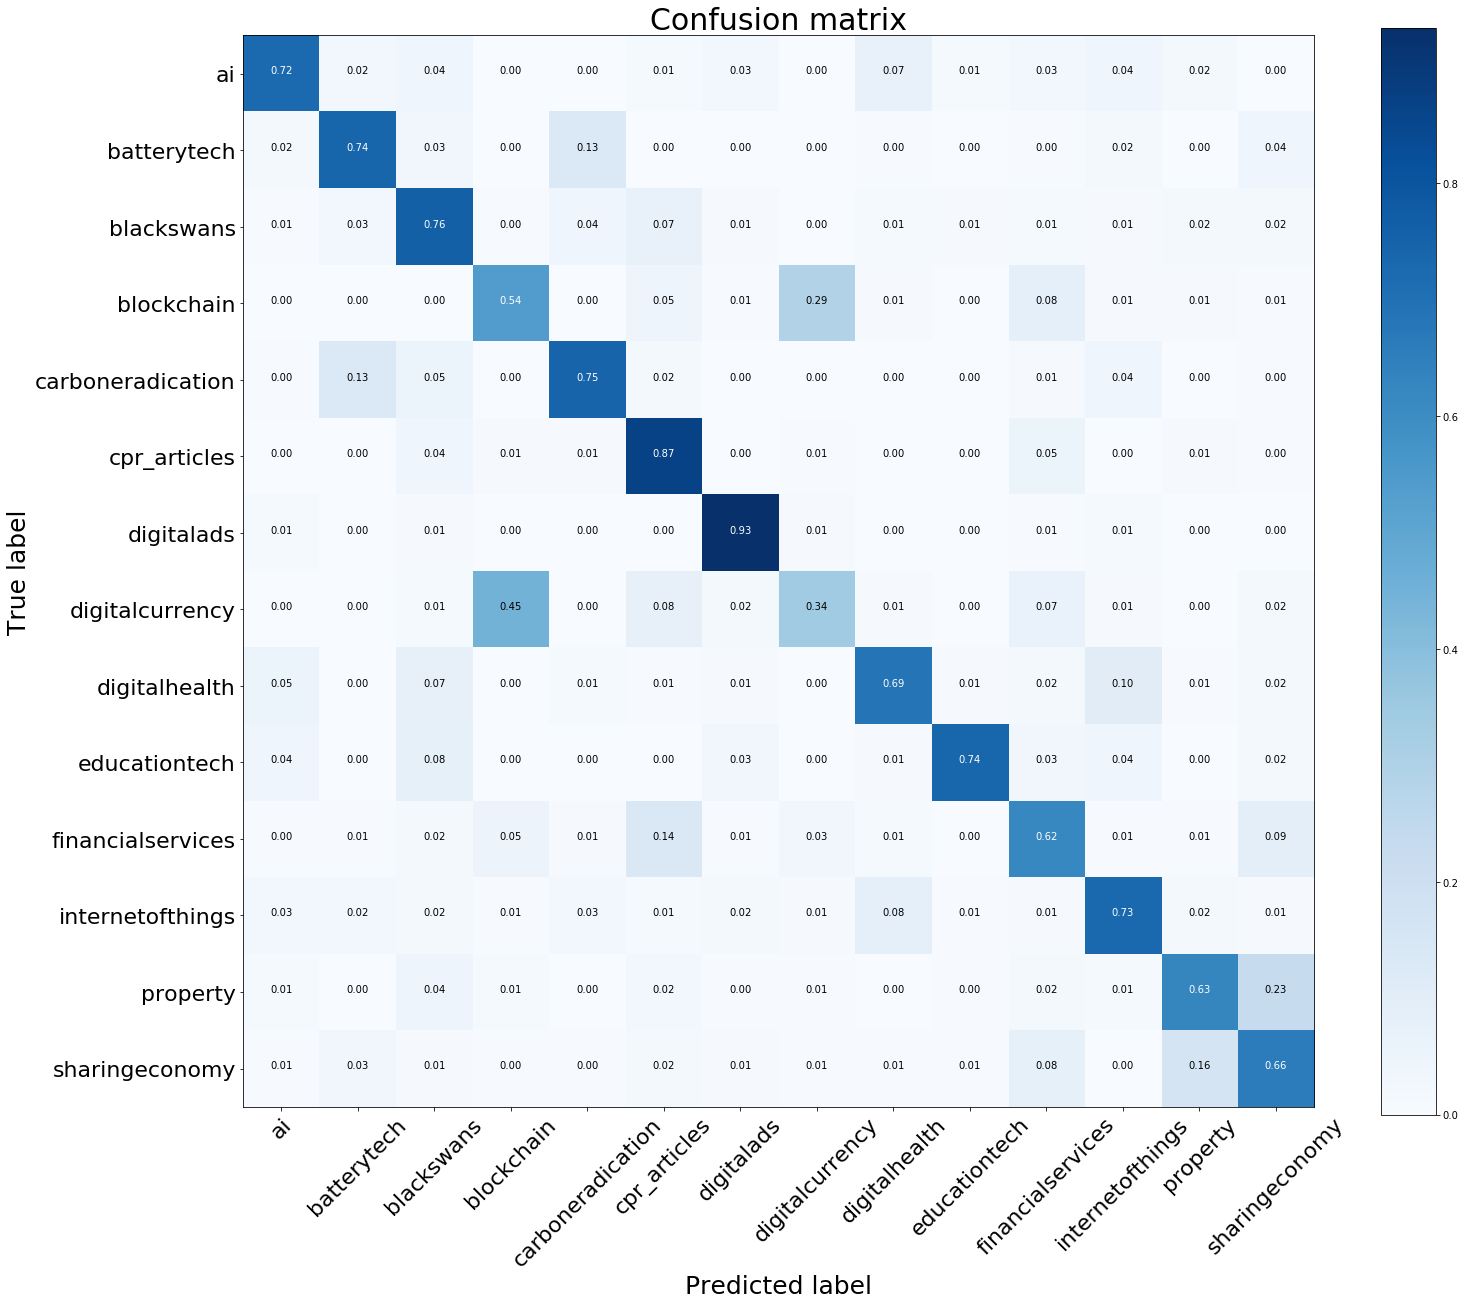

In [26]:
import itertools
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(24,20))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()

OK, so adding in the title field has improved the accuracy to 0.72. But that's still not as good as  the prediction accuracy of the SVM based on tf-idf we looked at in the first Capstone project, which averaged 0.77.